In [13]:
import pandas as pd

# Load the n-gram CSVs with smoothing already computed
unigram_df = pd.read_csv("unigram.csv")
bigram_df = pd.read_csv("bigram.csv")
trigram_df = pd.read_csv("trigram.csv")
quadrigram_df = pd.read_csv("quadrigram.csv")

print("Unigram sample:")
display(unigram_df.head())


Unigram sample:


,Ngram,Count,Add-One,Add-K,Token-Type
0,<s>,3000000,0.129863,0.130540,0.130540
1,</s>,1000000,0.043288,0.043513,0.043513
2,के,729215,0.031566,0.031731,0.031731
3,में,558379,0.024171,0.024297,0.024297
4,की,441848,0.019127,0.019226,0.019226


In [14]:
import random, re

bbc_df = pd.read_csv("bbc_hindi_articles_with_categories_cleaned.csv")

sentences = []
for text in bbc_df['Content'].dropna().tolist():
    # Keep punctuation with sentence using regex
    sents = re.findall(r'[^।.!?]+[।.!?]', text)

    # Clean + add <s> </s>
    sents = [f"<s> {s.strip()} </s>" for s in sents if len(s.strip()) > 0]
    sentences.extend(sents)

# Randomly pick 1000 sentences for evaluation
random.seed(42)
sampled_sentences = random.sample(sentences, min(1000, len(sentences)))

print("Total sampled sentences:", len(sampled_sentences))
print("Example sentence:", sampled_sentences[3])

Total sampled sentences: 1000
Example sentence: <s> मर्दाना ट्रोल समाज असल में दीपिका की बात से डर गया. </s>


In [15]:
import numpy as np

def prepare_ngram_dict(model, smoothing='Add-One'):
    """
    Convert model DataFrame into a dictionary for fast lookup.
    Returns: (ngram_dict, n)
    """
    ngram_dict = dict(zip(model['Ngram'], model[smoothing]))
    n = len(model.iloc[0]['Ngram'].split())  # n = ngram
    return ngram_dict, n

def sentence_logprob(sentence, ngram_dict, n):
    """
    Compute log probability of a sentence using a pre-built ngram_dict.
    """
    tokens = sentence.split()
    log_prob = 0.0
    
    for i in range(len(tokens)):
        if i + 1 < n:
            continue
        ngram = ' '.join(tokens[i-n+1:i+1])
        p = ngram_dict.get(ngram, 1e-12)  # unseen fallback
        log_prob += np.log(p if p > 0 else 1e-12)
    
    return log_prob


In [16]:
# ✅ Precompute dicts for fast lookup
uni_dict, uni_n = prepare_ngram_dict(unigram_df, 'Add-One')
bi_dict, bi_n   = prepare_ngram_dict(bigram_df, 'Add-One')
tri_dict, tri_n = prepare_ngram_dict(trigram_df, 'Add-One')
quad_dict, quad_n = prepare_ngram_dict(quadrigram_df, 'Add-One')

results = []
for s in sampled_sentences[:10]:
    res = {
        'Sentence': s,
        'Unigram_AddOne': sentence_logprob(s, uni_dict, uni_n),
        'Bigram_AddOne': sentence_logprob(s, bi_dict, bi_n),
        'Trigram_AddOne': sentence_logprob(s, tri_dict, tri_n),
        'Quadrigram_AddOne': sentence_logprob(s, quad_dict, quad_n)
    }
    results.append(res)

pd.DataFrame(results)


,Sentence,Unigram_AddOne,Bigram_AddOne,Trigram_AddOne,Quadrigram_AddOne
0,<s> नामांकन दाखिल करने के बाद समाचार एजेंसी एए...,-284.146705,-483.430141,-648.675399,-688.942915
1,<s> इनमें एक उनका नाम भी है. </s>,-67.355604,-127.519745,-134.134983,-138.155106
2,<s> फ़िल्म एक ढर्रे पर चल रही होती है तभी एक घ...,-259.242219,-520.765193,-710.584753,-746.037570
3,<s> मर्दाना ट्रोल समाज असल में दीपिका की बात स...,-116.582881,-234.148267,-287.066938,-276.310211
4,<s> जिन छात्रों को खाने की चीज़ों या किसी और च...,-221.101996,-431.788305,-524.997078,-580.517930
5,"<s> "" “कुछ समय पहले जब मैं समरकंद में\nराष्ट्र...",-241.912072,-461.523856,-645.975840,-704.560029
6,<s> घरेलू हिंसा के दायरे को समझना और उससे घरों...,-131.756081,-232.845024,-313.942222,-331.572253
7,"<s> "" वे दावा करते हैं, ""इसी बीच यहां के स्थान...",-316.991302,-569.594004,-758.457237,-746.037570
8,"<s> "" इस खदान की सुरक्षा के लिए इंडोनेशिया के ...",-301.762934,-605.823028,-836.040349,-913.905164
9,<s> यानी छात्रों के पास परीक्षा देने के लिए कं...,-203.929940,-390.617348,-498.165940,-538.437431


In [17]:
# ✅ Precompute dictionaries for all models and smoothing methods
def build_ngram_dicts(model, smoothings):
    n = len(model.iloc[0]['Ngram'].split())
    dicts = {}
    for sm in smoothings:
        dicts[sm] = dict(zip(model['Ngram'], model[sm]))
    return dicts, n

smoothings = ['Add-One' , 'Add-K' , 'Token-Type']

uni_dicts, uni_n   = build_ngram_dicts(unigram_df, smoothings)
bi_dicts, bi_n     = build_ngram_dicts(bigram_df, smoothings)
tri_dicts, tri_n   = build_ngram_dicts(trigram_df, smoothings)
quad_dicts, quad_n = build_ngram_dicts(quadrigram_df, smoothings)

models = [
    ('Unigram', uni_dicts, uni_n),
    ('Bigram', bi_dicts, bi_n),
    ('Trigram', tri_dicts, tri_n),
    ('Quadrigram', quad_dicts, quad_n)
]

# ✅ Faster log-prob function (dictionary lookup only)
def fast_sentence_logprob(sentence, ngram_dict, n):
    tokens = sentence.split()
    log_prob = 0.0
    for i in range(len(tokens)):
        if i + 1 < n:
            continue
        ngram = ' '.join(tokens[i-n+1:i+1])
        p = ngram_dict.get(ngram, 1e-12)
        log_prob += np.log(p if p > 0 else 1e-12)
    return log_prob

# ✅ Build results
final_results = []
for s in sampled_sentences:
    res = {'Sentence': s}
    for model_name, dicts, n in models:
        for sm in smoothings:
            key = f"{model_name}_{sm}"
            res[key] = fast_sentence_logprob(s, dicts[sm], n)
    final_results.append(res)

final_df = pd.DataFrame(final_results)
final_df.to_csv("sentence_logprobabilities.csv", index=False)
final_df.head()


,Sentence,Unigram_Add-One,Unigram_Add-K,Unigram_Token-Type,Bigram_Add-One,Bigram_Add-K,Bigram_Token-Type,Trigram_Add-One,Trigram_Add-K,Trigram_Token-Type,Quadrigram_Add-One,Quadrigram_Add-K,Quadrigram_Token-Type
0,<s> नामांकन दाखिल करने के बाद समाचार एजेंसी एए...,-284.146705,-284.007298,-284.007298,-483.430141,-483.431578,-513.259406,-648.675399,-644.170904,-568.744276,-688.942915,-686.089328,-614.288361
1,<s> इनमें एक उनका नाम भी है. </s>,-67.355604,-67.319413,-67.319413,-127.519745,-127.507399,-133.323141,-134.134983,-133.160647,-117.651734,-138.155106,-138.155106,-138.155106
2,<s> फ़िल्म एक ढर्रे पर चल रही होती है तभी एक घ...,-259.242219,-259.118494,-259.118494,-520.765193,-520.838216,-530.872214,-710.584753,-708.634885,-670.217985,-746.037570,-746.037570,-746.037570
3,<s> मर्दाना ट्रोल समाज असल में दीपिका की बात स...,-116.582881,-116.549314,-116.549314,-234.148267,-234.138262,-241.419023,-287.066938,-286.562919,-280.942166,-276.310211,-276.310211,-276.310211
4,<s> जिन छात्रों को खाने की चीज़ों या किसी और च...,-221.101996,-220.992737,-220.992737,-431.788305,-431.749954,-452.791674,-524.997078,-521.572540,-456.361145,-580.517930,-579.599175,-554.341053


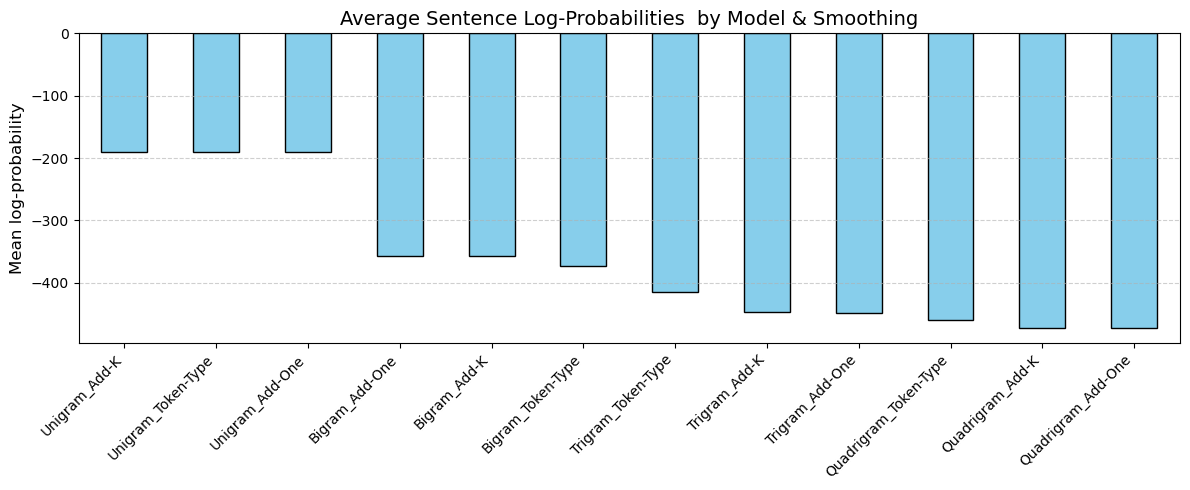

In [18]:
import matplotlib.pyplot as plt

avg_log_probs = final_df.drop(columns=['Sentence']).mean()

plt.figure(figsize=(12, 5))
avg_log_probs.sort_values(ascending=False).plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Average Sentence Log-Probabilities  by Model & Smoothing", fontsize=14)
plt.ylabel("Mean log-probability", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()